In [79]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=0adb946ebd0f90591a29338ed33dd92d6d9fed74a04771c4b01f7ac656ee6682
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
Successfully built efficientnet-pytorch


In [118]:
!pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git

  Cloning https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to /tmp/pip-req-build-jdn7ka_r
  Running command git clone -q https://github.com/ildoonet/pytorch-gradual-warmup-lr.git /tmp/pip-req-build-jdn7ka_r
  Created wheel for warmup-scheduler: filename=warmup_scheduler-0.3.2-py3-none-any.whl size=3881 sha256=8ac74a10b104219777971f2f1fb0d7544b1e6288e34d259dad15fa17e476ec11
  Stored in directory: /tmp/pip-ephem-wheel-cache-uzff750o/wheels/bf/81/52/0e3bc0b645a339f94c76b4dcb8c8b7a5f588a614f5add83b9f
Successfully built warmup-scheduler


In [119]:
import os
import sys
sys.path = [
    '../input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master',
] + sys.path

In [120]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd, numpy as np
from tqdm.notebook import tqdm
from PIL import Image
import cv2
from sklearn.metrics import f1_score

import os, gc, time, math, random

In [121]:
# Pytourch modules
import torch
import torchvision.models as models
import torchvision.transforms as T
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
from torch.utils.data import Dataset, random_split, DataLoader
from efficientnet_pytorch import model as enet

In [123]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

## Preparing the Data

In [124]:
DATA_DIR = '../input/jovian-pytorch-z2g/Human protein atlas'

TRAIN_DIR = DATA_DIR + '/train'                           
TEST_DIR = DATA_DIR + '/test'                             

TRAIN_CSV = DATA_DIR + '/train.csv'                       
TEST_CSV = '../input/jovian-pytorch-z2g/submission.csv' 

SEED = 652

In [125]:
enet_type = 'efficientnet-b0'
out_dim = 5

In [126]:
data_df = pd.read_csv(TRAIN_CSV)
# data_df.head()

In [127]:
labels = {
    0: 'Mitochondria',
    1: 'Nuclear bodies',
    2: 'Nucleoli',
    3: 'Golgi apparatus',
    4: 'Nucleoplasm',
    5: 'Nucleoli fibrillar center',
    6: 'Cytosol',
    7: 'Plasma membrane',
    8: 'Centrosome',
    9: 'Nuclear speckles'
}

In [128]:
def encode_label(label):
    target = torch.zeros(10)
    for l in str(label).split(' '):
        target[int(l)] = 1.
    return target

def decode_target(target, text_labels=False, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            if text_labels:
                result.append(labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return ' '.join(result)

In [129]:
from skimage import io, color
from PIL import Image
from matplotlib import cm
class HumanProteinDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['Image'], row['Label']
        img_fname = self.root_dir + "/" + str(img_id) + ".png"
#         img = Image.open(img_fname)
        rgb = io.imread(img_fname)
        image = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
        image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0,0) ,256/10), -4, 128)
        img = Image.fromarray(image.astype('uint8'), 'RGB')
        if self.transform:
            img = self.transform(img)
        return img, encode_label(img_label)

### Data augmentations

In [130]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_tfms = T.Compose([
    T.RandomCrop(512, padding=8, padding_mode='reflect'),
    T.RandomResizedCrop(512, scale=(0.5,0.9), ratio=(1, 1)), 
#     T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.RandomRotation(10),
    T.ToTensor(), 
    T.Normalize(*imagenet_stats,inplace=True), 
#     T.RandomErasing(inplace=True)
])

valid_tfms = T.Compose([
    T.Resize(512), 
    T.ToTensor(), 
    T.Normalize(*imagenet_stats)
])

In [131]:
seed_everything(SEED)
msk = np.random.rand(len(data_df)) < 0.9

train_df = data_df[msk].reset_index()
val_df = data_df[~msk].reset_index()

In [132]:
train_ds = HumanProteinDataset(train_df, TRAIN_DIR, transform=train_tfms)
val_ds = HumanProteinDataset(val_df, TRAIN_DIR, transform=valid_tfms)
len(train_ds), len(val_ds)

(17290, 1946)

In [133]:
def show_sample(img, target, invert=True):
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))
    print('Labels:', decode_target(target, text_labels=True))

Labels: Nucleoli(2) Nucleoplasm(4)


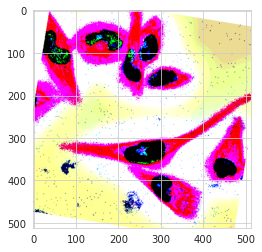

In [134]:
show_sample(*train_ds[1541])

### DataLoaders

In [96]:
batch_size = 64

In [97]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, 
                      num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, 
                    num_workers=4, pin_memory=True)

In [98]:
def show_batch(dl, invert=True):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(data, nrow=16).permute(1, 2, 0))
        break

In [99]:
# show_batch(train_dl, invert=True)

## Model - Transfer Learning

In [100]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [109]:
class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.binary_cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.binary_cross_entropy(out, targets)  # Calculate loss
        score = F_score(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_score']))

In [110]:
# resnet34 = models.resnet34()
# resnet34

In [111]:
class ProteinResnet(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.BatchNorm1d(num_ftrs),
            nn.Dropout(0.25),
            nn.Linear(num_ftrs, 128, bias=True),
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm1d(128, momentum=0.01),
            nn.Linear(128, 64, bias=True),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(64, 10)
        )
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [ ]:
pretrained_model = {
    'efficientnet-b0': '../input/efficientnet-pytorch/efficientnet-b0-08094119.pth'
}

In [ ]:
class enetv2(nn.Module):
    def __init__(self, backbone, out_dim):
        super(enetv2, self).__init__()
        self.enet = enet.EfficientNet.from_name(backbone)
        self.enet.load_state_dict(torch.load(pretrained_model[backbone]))

        self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)
        self.enet._fc = nn.Identity()

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        x = self.extract(x)
        x = self.myfc(x)
        return x

In [112]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [113]:
device = get_default_device()
device

device(type='cpu')

In [114]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

## Training

In [115]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.AdamW):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [116]:
model = to_device(ProteinResnet(), device)
model

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b6-c76e70fd.pth" to /root/.cache/torch/checkpoints/efficientnet-b6-c76e70fd.pth



Loaded pretrained weights for efficientnet-b6


ProteinResnet(
  (network): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 56, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(56, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          56, 56, kernel_size=(3, 3), stride=[1, 1], groups=56, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(56, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          56, 14, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          14, 56, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
      

In [117]:
history = [evaluate(model, val_dl)]
history

RuntimeError: DataLoader worker (pid 93) is killed by signal: Killed. 

First, freeze the ResNet layers and train some epochs. This only trains the final layer to start classifying the images.

In [ ]:
gc.collect()

In [ ]:
model.freeze()

In [ ]:
epochs = 1
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
seed_everything(SEED)

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

In [ ]:
gc.collect()

Now, unfreeze and train some more.

In [ ]:
model.unfreeze()

In [ ]:
%%time
history += fit_one_cycle(epochs, 0.001, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

In [ ]:
gc.collect()

In [ ]:
train_time='22:00'

In [ ]:
def plot_scores(history):
    scores = [x['val_score'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score vs. No. of epochs');

In [ ]:
plot_scores(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
plot_losses(history)

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

In [ ]:
plot_lrs(history)

## Making predictions and submission

In [ ]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    print("Prediction: ", prediction)
    show_sample(image, prediction)

In [ ]:
test_df = pd.read_csv(TEST_CSV)
test_dataset = HumanProteinDataset(test_df, TEST_DIR, transform=valid_tfms)

In [ ]:
img, target = test_dataset[0]
img.shape

In [ ]:
predict_single(test_dataset[74][0])

In [ ]:
test_dl = DeviceDataLoader(DataLoader(test_dataset, batch_size, num_workers=4, pin_memory=True), device)

In [ ]:
@torch.no_grad()
def predict_dl(dl, model):
    torch.cuda.empty_cache()
    batch_probs = []
    for xb, _ in tqdm(dl):
        probs = model(xb)
        batch_probs.append(probs.cpu().detach())
    batch_probs = torch.cat(batch_probs)
    return [decode_target(x) for x in batch_probs]

In [ ]:
seed_everything(SEED)
test_preds = predict_dl(test_dl, model)

In [ ]:
gc.collect()

In [ ]:
submission_df = pd.read_csv(TEST_CSV)
submission_df.Label = test_preds
submission_df.sample(20)

In [ ]:
sub_fname = 'submission.csv'

In [ ]:
submission_df.to_csv(sub_fname, index=False)

## Save and Commit

In [ ]:
weights_fname = 'protein-resnet.pth'
torch.save(model.state_dict(), weights_fname)

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import jovian

In [ ]:
jovian.reset()
jovian.log_hyperparams(arch='resnet34', 
                       epochs=2*epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

In [ ]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_score=history[-1]['val_score'],
                   train_loss=history[-1]['train_loss'],
                   time=train_time)

In [ ]:
project_name='protein-advanced'

In [ ]:
jovian.commit(project=project_name, environment=None, outputs=[weights_fname])